All traded assets are illiquid. The bid ask spread, measuring
the difference between the price at which you can buy and sell
the asset at the same point in time is the illiquidity measure.

We can regress the bid-ask spread (as a percent of the
price) against variables that can be measured for a private
firm (such as revenues, cash flow generating capacity, type of
assets, variance in operating income) and are also available for
publicly traded firms.

Using data from the end of 2000, for instance, we regressed the
bid-ask spread against annual revenues, a dummy variable for
positive earnings (DERN: 0 if negative and 1 if positive), cash as
a percent of firm value and trading volume.
    § Spread = 0.145 - 0.0022 ln (Annual Revenues) -0.015 (DERN) - 0.016 (Cash/Firm Value) - 0.11 ($ Monthly trading volume/ Firm Value)
    § You could plug in the values for a private firm into this regression (with zero trading volume) and estimate the spread for the firm.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from download_company import Company, YahooFinance

### If you want to avoid running the download code below because you already have the dataset, edit the cell below

In [2]:
# Inputs
use_cache = True
dataset_name = 'small_usa'

In [3]:
df = None
if use_cache:
    dataset_file = dataset_name + '_dataset.xlsx'
    df = pd.read_excel(dataset_file, index_col=0)

### Importing Data from NASDAQ
1. Go to the NASDAQ website: [NASDAQ](https://www.nasdaq.com/market-activity/stocks/screener)
2. Filter the list of companies
3. Download the list as CSV
4. Rename the file to stocks.csv and add it to this folder

In [4]:
stock_symbols = None
if not use_cache:
    stock_symbols_file = dataset_name + '.csv'
    nasdaq_df = pd.read_csv(stock_symbols_file)
    print(nasdaq_df.iloc[:2])

    stock_symbols = nasdaq_df.Symbol
    print(stock_symbols.shape)

It is highly likely that most of these 1783 symbols will not have the data we need, so hopefully we shoot for the moon and land in the stars.

Let's collect all these symbols into a dataset using our helper class:

In [5]:
if not use_cache:
    # Download required data from companies
    downloader = YahooFinance()

    data = downloader.download_companies(stock_symbols)

    df = pd.DataFrame()
    for ticker, company in data.items():
        df = pd.concat([df, company.get_df()])
df.head()

,Log Revenues,DERN,Cash-to-EV,Volume-to-EV,Debt-to-EV,Bid-Ask Spread
AAOI,19.334428,0,0.077842,0.102973,0.220337,0.529133
AAP,22.930917,0,0.437176,0.025671,0.970004,0.001543
ABL,18.533329,0,0.126212,0.002712,0.369148,0.007246
ABSI,15.327115,1,0.396559,0.049813,0.035644,0.316695
AC,16.393832,1,0.879908,0.000487,0.000000,0.040659


Save dataset to Excel file for manual processing

In [6]:
if not use_cache:
    df.to_excel(dataset_file)

### Statistical Analysis

In [7]:
df.describe()

,Log Revenues,DERN,Cash-to-EV,Volume-to-EV,Debt-to-EV,Bid-Ask Spread
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,19.785132,0.673489,0.117964,0.012278,0.369931,0.143145
std,1.703483,0.469165,6.550295,0.138846,0.553069,0.235261
min,9.903488,0.000000,-156.313740,-3.252626,-5.572438,0.000147
25%,19.002098,0.000000,0.032611,0.003316,0.093526,0.002683
50%,19.862059,1.000000,0.103376,0.007449,0.321975,0.009596
75%,20.909965,1.000000,0.279876,0.014558,0.578001,0.268805
max,24.428734,1.000000,80.018027,2.485199,10.681107,1.817479


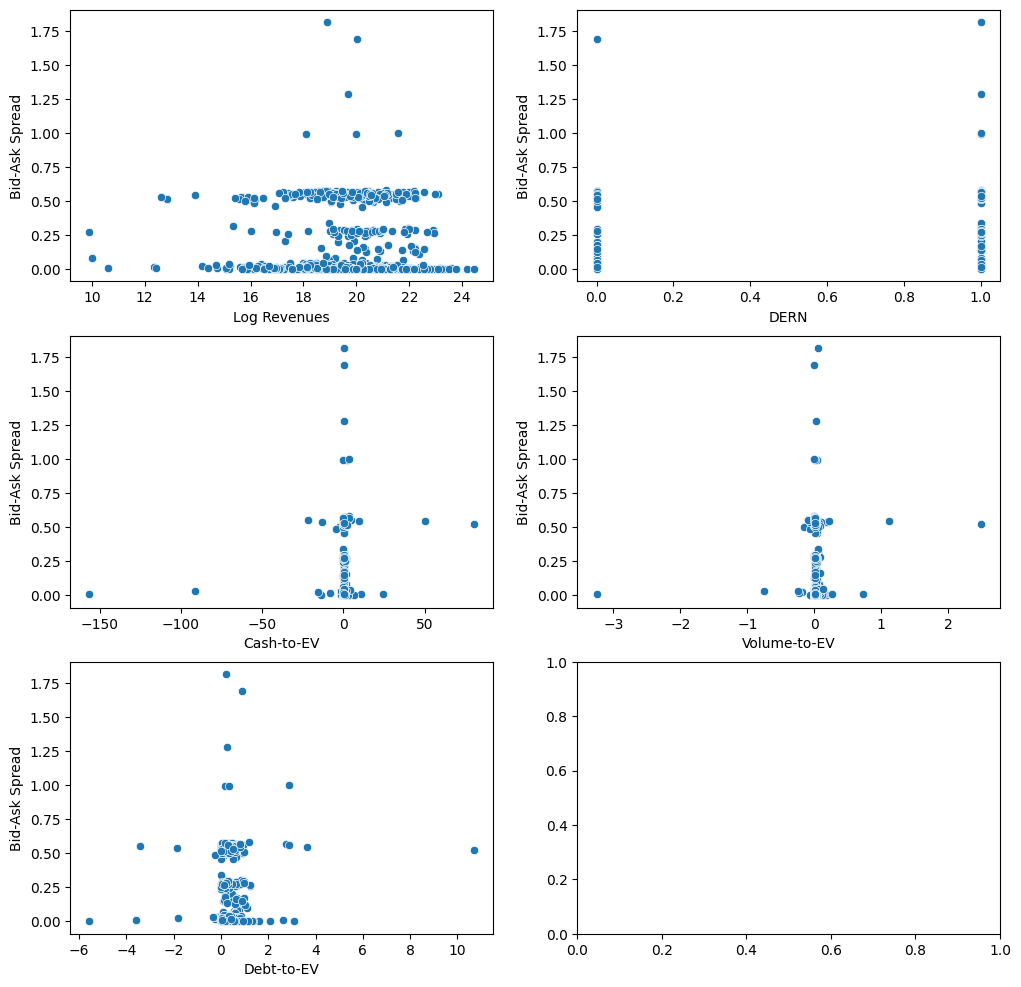

In [8]:
features_str = list(df.columns)
features_str.remove(Company.dependent_variable_name)
spread_col = Company.dependent_variable_name

fig, ax = plt.subplots(len(features_str) // 2 + 1, 2)
fig.set_size_inches(12, 12)
for i, feature in enumerate(features_str):
    sns.scatterplot(df[[feature, spread_col]], x=feature, y=spread_col, ax=ax[i//2][i%2])

### Regression Analysis

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(train_df.shape)
print(test_df.shape)

(820, 6)
(206, 6)


In [10]:
spread_col = Company.dependent_variable_name

X_train = train_df.loc[:, train_df.columns != spread_col]
y_train = train_df.loc[:, spread_col]
print(X_train.shape)
print(y_train.shape)

X_test = test_df.loc[:, test_df.columns != spread_col]
y_test = test_df.loc[:, spread_col]
print(X_test.shape)
print(y_test.shape)

(820, 5)
(820,)
(206, 5)
(206,)


Fitting a model with Linear Regression

In [11]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Calculating R^2 score
y_hat = model_linear.predict(X_test)
print('R^2 score on linear regression:', r2_score(y_test, y_hat))
print()
for i, feature in enumerate(model_linear.feature_names_in_):
    print(f"Coefficient on {feature:<15}: {model_linear.coef_[i]}")

R^2 score on linear regression: -0.02938295982927497

Coefficient on Log Revenues   : -0.016163068715135984
Coefficient on DERN           : -0.002368600741624545
Coefficient on Cash-to-EV     : 0.003029033305214843
Coefficient on Volume-to-EV   : -0.10417331240961863
Coefficient on Debt-to-EV     : 0.027388217336009334


Fitting a model with LASSO Regression

In [12]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Calculating R^2 score
y_hat = model_lasso.predict(X_test)
print('R^2 score on LASSO regression:', r2_score(y_test, y_hat))
print()
for i, feature in enumerate(model_lasso.feature_names_in_):
    print(f"Coefficient on {feature:<15}: {model_lasso.coef_[i]}")

R^2 score on LASSO regression: -0.002264222463308707

Coefficient on Log Revenues   : -0.0
Coefficient on DERN           : 0.0
Coefficient on Cash-to-EV     : 0.00028263626689710143
Coefficient on Volume-to-EV   : 0.0
Coefficient on Debt-to-EV     : 0.0


Fitting a model with Decision Trees

R^2 score on Decision Tree regression: -0.0919618247100693


<Axes: >

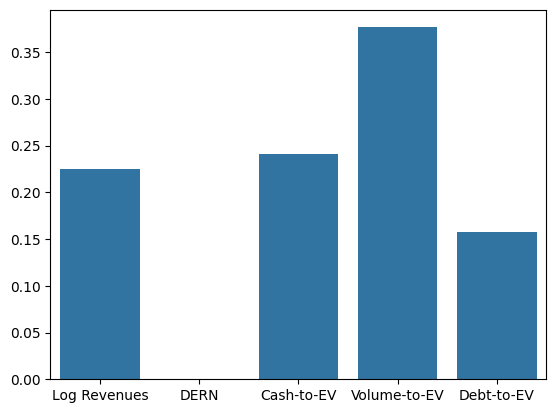

In [13]:
model_forest = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1)
model_forest.fit(X_train, y_train)

# Calculating R^2 score
print('R^2 score on Decision Tree regression:', model_forest.score(X_test, y_test))

importances = model_forest.feature_importances_

forest_importances = pd.Series(importances, index=model_forest.feature_names_in_)
sns.barplot(forest_importances)

In [14]:
model_rf = RandomForestRegressor(n_estimators=10, max_features=2)
model_rf.fit(X_train, y_train)

# Calculating R^2 score
print('R^2 score on Random Forests non-linear regression:', model_rf.score(X_test, y_test))

R^2 score on Random Forests non-linear regression: -0.11966999894677133
